# Noisy Partials

This notebook explores the effect of noisy partials and whether or not the hyperparameter $\gamma$ can mitigate it. 

### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jenn
from jenn.utils import plot
from jenn.utils.metrics import r_square

### Notebook Support Functions

In [2]:
def generate_training_data(step_size: float = 1e-6, seed: int = 123):
    """Generate training data using finite difference."""
    test_function = jenn.synthetic.Rastrigin
    lb = (-1.0, -1.0)
    ub = (1.5, 1.5)
    X_train, Y_train, J_train = test_function.sample(
        m_lhs=100,
        m_levels=0,
        lb=lb,
        ub=ub,
        dx=None,
        random_state=seed,
    )  # analytical partials
    X_train_FD, Y_train_FD, J_train_FD = test_function.sample(
        m_lhs=100,
        m_levels=0,
        lb=lb,
        ub=ub,
        dx=step_size,
        random_state=seed,
    )  # finite difference
    X_test, Y_test, J_test = test_function.sample(
        m_lhs=0,
        m_levels=10,
        lb=lb,
        ub=ub,
        random_state=seed,
    )
    return (
        (X_train, Y_train, J_train),
        (X_train_FD, Y_train_FD, J_train_FD),
        (X_test, Y_test, J_test),
    )

In [3]:
def fit_rastrigin(step_size: float = 1e-6, gamma: float = 1.0, seed: int = 123):
    """Generate training data and fit Rastrigin function.

    :param step_size: finite difference step size for training data partials
    """
    # Training data
    (
        (X_train, Y_train, _),
        (_, _, J_train_FD),
        (X_test, Y_test, _),
    ) = generate_training_data(step_size)

    # Train neural net
    model = jenn.model.NeuralNet(
        layer_sizes=[2, 24, 24, 1],
    ).fit(
        x=X_train,
        y=Y_train,
        dydx=J_train_FD,
        max_iter=5_000,
        alpha=0.001,
        lambd=0.001,
        gamma=gamma,
        is_normalize=True,
        random_state=seed,
    )

    # Goodness of fit
    r2 = r_square(
        y_pred=model.predict(X_test),
        y_true=Y_test,
    ).squeeze()

    return model, r2

### Check Support Functions

_Verify support function convergence._

In [4]:
model, r2 = fit_rastrigin(step_size=None, gamma=1.0)

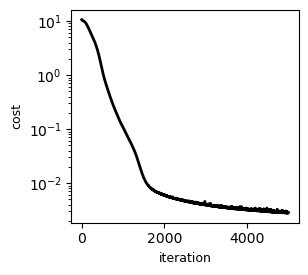

In [5]:
plot.convergence(histories=[model.history])

### Trade Study

Plot how R-Squared varies as a function of finite difference step size and hyperparameter $\gamma$. 

#### R-Squared Data

In [6]:
%%time
step_sizes = [
    1e-6,
    1e-4,
    1e-2,
    1e-1,
    0.15,
    0.20,
    0.25,
    0.30,
    0.35,
    0.40,
    0.45,
    0.50,
    0.55,
    0.60,
    0.65,
    0.75,
    0.80,
    0.85,
    0.90,
    0.95,
    1.0,
]
gammas = [0.0, 0.25, 0.5, 0.75, 1.0]
r2 = np.zeros((len(gammas), len(step_sizes)))
for j, step_size in enumerate(step_sizes):
    for i, gamma in enumerate(gammas):
        r2[i, j] = fit_rastrigin(step_size, gamma)[1]

CPU times: user 5min 20s, sys: 883 ms, total: 5min 21s
Wall time: 5min 21s


#### Finite Difference Error

In [7]:
errors = []
for j, step_size in enumerate(step_sizes):
    (
        (_, _, J_train),
        (_, _, J_train_FD),
        (_, _, _),
    ) = generate_training_data(step_size)
    error = (abs(J_train - J_train_FD) / J_train * 100).mean()
    errors.append(error)

#### Visualization

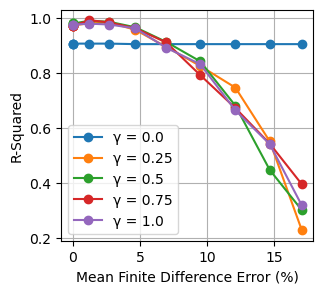

In [8]:
start = 0
stop = -10
gamma = "\u03b3"
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.0))
plt.plot(errors[start:stop], r2[:, start:stop].T, "o-")
plt.grid(True)
plt.xlabel("Mean Finite Difference Error (%)")
plt.ylabel("R-Squared")
plt.legend([f"{gamma} = {value}" for value in gammas])
# ax.set_xscale('log')
fig.savefig("noisy_partials.pdf", bbox_inches="tight")

### Conclusions

On average, beyond 5% error in the partials, the benefit of gradient-enhancement vanishes but, below that threshold, JENN (where $\gamma > 0$) still outperforms NN (where $\gamma = 0$). This implies that partials need not be perfectly accurate, provided they point in the correct direction. However, beyond 5% error, the opposite is true: partials are too inaccurate to be useful and, in that case, simple NN are the better choice. The results further reveal that there is no benefit to settings the hyperparameter $\gamma$ to values between zero and one; it does not mitigate the effect of noisy partials. Consequently,  $\gamma$ should be treated as a binary hyperparameter: $\gamma = 1$ for JENN and $\gamma = 0$ for NN. 

> Note: There are only two reasons to set $\gamma$ to values other than zero or one: polishing or incomplete partials. An example of the former is provided in the surrogate-based optimization notebook. The latter occurs when partials are only avialable for some inputs in the training data. In that case, the missing partials can be ignored from the learning problem by setting their corresponing $gamma$ to zero. 